In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping


2023-03-07 19:46:15.084499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = os.getcwd() #Find the current directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  path+'/Data/', #Find the folder called Data inside the same directory
  labels = 'inferred', #Uses the names of the folders inside Data as the labels for the classification classes
  color_mode='rgb', #Color images
  validation_split=0.2, #Use 80% of images for training, 20% for validation
  subset="training", #This is the traininng dataset
  seed=123, #Seed the draw so that the validation set and the traning set don't overlap
  image_size=(224, 224), #Enforce a good image size for our model
  crop_to_aspect_ratio = True) #Crop the image to fit the good size; playing around with this might be interesting?

#Same thing as above but for the validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  path+'/Data/',
  labels = 'inferred',
  color_mode='rgb',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  crop_to_aspect_ratio = True)


normalization_layer = tf.keras.layers.Rescaling(1./255)

#If you want to try playing around with data augmentation, this is the infrastructure needed to do so.
AUTOTUNE = tf.data.AUTOTUNE
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


#Normalize the dataset from 0 -> 255 to 0 —> 1
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

#Uncomment the below to try with data augmentation!
#augmented = normalized_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
#                num_parallel_calls=AUTOTUNE)



Found 961 files belonging to 4 classes.
Using 769 files for training.
Found 961 files belonging to 4 classes.
Using 192 files for validation.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-07 19:46:42.168050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


['allPlastic', 'noPlastic', 'noimg', 'somePlastic']
0.0 1.0


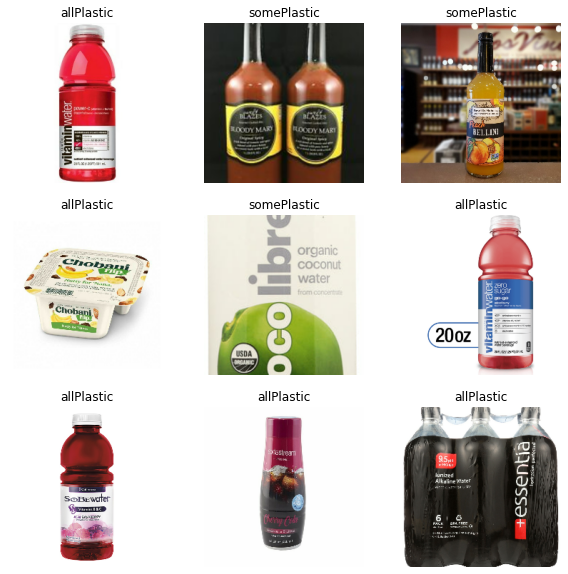

In [3]:
class_names = train_ds.class_names
print(class_names)

first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [4]:
IMAGE_SIZE = 224
vgg = keras.applications.VGG19(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = keras.layers.Flatten()(vgg.output)
prediction = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [10]:
#An early stopping routine to prevent overfitting if the validation loss goes up too many times in a row
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)

#An example of traning with the unnormalized data sets; you should see roughly 90% validation accuracy! Pretty cool.
history = model.fit(train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)
model.save('trainedModel') #save the model


25/25 [==============================] - 153s 6s/step - loss: 0.6447 - accuracy: 0.9688 - val_loss: 6.6837 - val_accuracy: 0.8646


AttributeError: 'History' object has no attribute 'save'

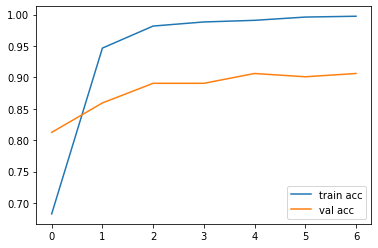

In [7]:
#Plot the accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()



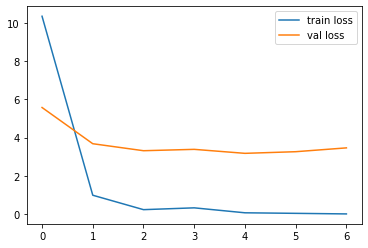

In [8]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [9]:
#Fine tune the model; doesn't do much good without more data (or maybe data augmentation?)

for layer in vgg.layers:
    layer.trainable = True
model.compile( #Recompile the model with the layers unlocked
  loss='sparse_categorical_crossentropy',
  optimizer=keras.optimizers.Adam(1e-5), #Learn SLOWLY to avoid over
  metrics=['accuracy']
)
model.fit(train_ds, epochs=10, callbacks=early_stop, validation_data=val_ds)
model.save('fineTunedModel')

Epoch 1/10
25/25 [==============================] - 165s 7s/step - loss: 0.0242 - accuracy: 0.9961 - val_loss: 3.3447 - val_accuracy: 0.9010
Epoch 2/10
25/25 [==============================] - 5784s 241s/step - loss: 0.0137 - accuracy: 0.9974 - val_loss: 3.2870 - val_accuracy: 0.9010
Epoch 3/10
25/25 [==============================] - 163s 7s/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 3.2417 - val_accuracy: 0.8958
Epoch 4/10
25/25 [==============================] - 161s 6s/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 3.2106 - val_accuracy: 0.8958
Epoch 5/10
25/25 [==============================] - 181s 7s/step - loss: 0.0015 - accuracy: 0.9987 - val_loss: 3.1924 - val_accuracy: 0.8958
Epoch 6/10
25/25 [==============================] - 209s 8s/step - loss: 5.0006e-04 - accuracy: 1.0000 - val_loss: 3.1842 - val_accuracy: 0.8958
Epoch 7/10
25/25 [==============================] - 4162s 173s/step - loss: 2.7000e-04 - accuracy: 1.0000 - val_loss: 3.1778 - val_accuracy: 0.9010

In [10]:
#If you want to play around with a b7 model instead of the VGG used above, uncomment the below cell!
#b7 = keras.applications.EfficientNetB7(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
'''
for layer in b7.layers:
    layer.trainable = False
x = keras.layers.Flatten()(b7.output)
prediction = keras.layers.Dense(4, activation='softmax')(x)

model = keras.Model(inputs=b7.input, outputs=prediction)
model.summary()

model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

history = model.fit(train_ds, epochs=10, callbacks=early_stop, validation_data=val_ds)
'''

258076736/258076736 [==============================] - 14s 0us/step


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']    

Epoch 1/10
25/25 [==============================] - 210s 8s/step - loss: 3.9861 - accuracy: 0.6671 - val_loss: 2.1498 - val_accuracy: 0.8281
Epoch 2/10
25/25 [==============================] - 186s 7s/step - loss: 0.8304 - accuracy: 0.9012 - val_loss: 1.2056 - val_accuracy: 0.8854
Epoch 3/10
25/25 [==============================] - 182s 7s/step - loss: 0.3811 - accuracy: 0.9454 - val_loss: 2.3689 - val_accuracy: 0.8281
Epoch 4/10
25/25 [==============================] - 198s 8s/step - loss: 0.4769 - accuracy: 0.9467 - val_loss: 1.6077 - val_accuracy: 0.8594
Epoch 4: early stopping
